In [1]:
from utils.paths_to_files import *
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette("Set2")
import matplotlib.pyplot as plt
import IPython.display as ipd
from utils.utils import *
from utils.classificationEvaluation import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# 1. Defining the task and splitting the data
The objective is to construct a decision tree that can predict the music genre of a track using its audio features (explained in the "audio_features_EDA" notebook). The primary challenge will be handling the dataset's high dimensionality and imbalanced target classes, as indicated below.

We will build several decision trees using different feature subsets (or transformations of the features) and analyse their results on the validation set.
Afterward, we will build a Random Forest classifier and compare it to the previous models.

To address the imbalance we will employ a stratified split while dividing the data, although in subsequent project iterations, we aim to integrate metadata into the splitting process to ensure that all subsets (training, validation, and testing) have high-quality data.

In [2]:
df = pd.read_csv(FEATURES_PATH_PROCESSED, index_col=0, header=[0, 1, 2])

# Genre column has no inner levels
df = df.rename(columns={'Unnamed: 253_level_1': '', 'Unnamed: 253_level_2' : ''})

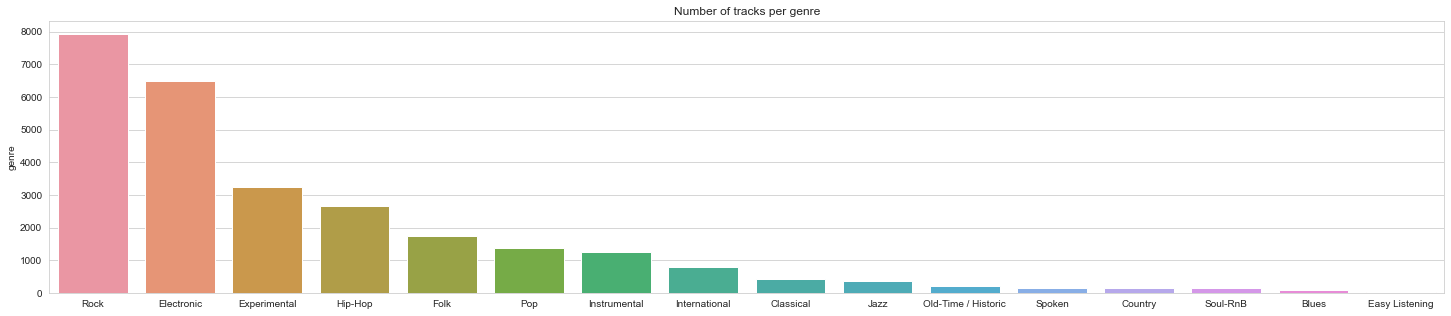

In [3]:
plt.figure(figsize=(25, 5))
sns.barplot(x=df['genre'].value_counts().index, y=df['genre'].value_counts())
plt.title('Number of tracks per genre')
plt.show()

## 1.1 Train, validation, test split

In [4]:
train_set, test_set = train_test_split(df, test_size=0.1, stratify=df['genre'], random_state=123)
train_set, val_set = train_test_split(train_set, test_size=0.1, stratify=train_set['genre'], random_state=123)

train_value_counts = train_set['genre'].value_counts(normalize=True) * 100.0
validation_value_counts = val_set['genre'].value_counts(normalize=True) * 100.0
test_value_counts = test_set['genre'].value_counts(normalize=True) * 100.0

train_value_counts.name = 'train %'
test_value_counts.name = 'validation %'
test_value_counts.name = 'test %'

train_set_indexes = train_set.index
val_set_indexes = val_set.index
test_set_indexes = test_set.index

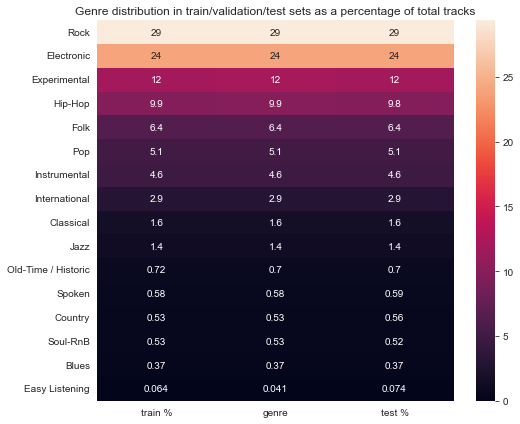

In [5]:
plt.figure(figsize=(8, 7))
sns.heatmap(
    pd.concat([train_value_counts, validation_value_counts, test_value_counts], axis=1),
    annot=True,
    vmin=0
)
plt.title("Genre distribution in train/validation/test sets as a percentage of total tracks")
plt.show()

## 1.2 Feature subsets

In [6]:
def scale_data(train_X, val_X, test_X, scaler):
    train_X = train_X.copy()
    val_X = val_X.copy()
    test_X = test_X.copy()

    train_X = pd.DataFrame(scaler.fit_transform(train_X), index=train_X.index, columns=train_X.columns)
    val_X = pd.DataFrame(scaler.transform(val_X), index=val_X.index, columns=val_X.columns)
    test_X = pd.DataFrame(scaler.transform(test_X), index=test_X.index, columns=test_X.columns)

    return train_X, val_X, test_X

df_1 contains only MFCC features

In [7]:
# MFCCs are considered to be highly informative, so it is worth trying to build a model using only these features
df_1 = df['mfcc'].copy()

df_2 contains ['mfcc', 'spectral_centroid', 'spectral_contrast', 'rmse', 'tonnetz', 'zcr', 'chroma_cqt'] features (with some changes)

In [8]:
# We select only spectral_centroid because of the high correlation with spectral_bandwidth and spectral_rolloff
slice_1 = pd.IndexSlice[['mfcc', 'spectral_centroid', 'spectral_contrast', 'rmse', 'tonnetz', 'zcr']]

# Select all features of chroma_cqt, except max (most of the values are 1s)
slice_2 = pd.IndexSlice['chroma_cqt', ('kurtosis', 'mean', 'median', 'min', 'skew', 'std')]

df_2 = pd.concat([df.loc[:, slice_1], df.loc[:, slice_2]], axis=1).copy()

df_3 is the result of applying PCA to df_2

In [9]:
# To prevent leakage of information from the validation and test sets
df_3_train = df_2.loc[train_set_indexes, :].copy()
df_3_val = df_2.loc[val_set_indexes, :].copy()
df_3_test = df_2.loc[test_set_indexes, :].copy()

# Scaling the features before applying PCA
df_3_train, df_3_val, df_3_test = scale_data(df_3_train, df_3_val, df_3_test, StandardScaler())

# Select the number of components such that the amount of variance that needs to be explained is greater than 95%
pca = PCA(n_components=0.95)
df_3_train = pd.DataFrame(pca.fit_transform(df_3_train), index=df_3_train.index)
df_3_val = pd.DataFrame(pca.transform(df_3_val), index=df_3_val.index)
df_3_test = pd.DataFrame(pca.transform(df_3_test), index=df_3_test.index)

In [10]:
datasets_X = {
    'df_1' : {
        'train' : df_1.loc[train_set_indexes, :],
        'val' : df_1.loc[val_set_indexes, :],
        'test' : df_1.loc[test_set_indexes, :],
    },
    'df_2' : {
        'train' : df_2.loc[train_set_indexes, :],
        'val' : df_2.loc[val_set_indexes, :],
        'test' : df_2.loc[test_set_indexes, :],
    },
    'df_3' : {
        'train' : df_3_train,
        'val' : df_3_val,
        'test' : df_3_test
    },
}

In [11]:
for name, dataset in datasets_X.items():
    print(name)
    print(dataset['train'].shape, dataset['val'].shape, dataset['test'].shape)

df_1
(21877, 140) (2431, 140) (2701, 140)
df_2
(21877, 324) (2431, 324) (2701, 324)
df_3
(21877, 150) (2431, 150) (2701, 150)


# 2. Training the models

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
# Stores the name of the model, and the appropriate DecisionTreeClassifier object
models = {}

for model_name, dataset_X in datasets_X.items():
    dt = DecisionTreeClassifier(criterion='gini', max_depth=50, min_samples_split=100, random_state=123)

    train_X = dataset_X['train']
    train_y = df.loc[train_set_indexes, 'genre']

    dt.fit(train_X, train_y)
    models[model_name] = dt

In [14]:
model_evaluations = {}
for model_name, model in models.items():
    train_X = datasets_X[model_name]['train']
    train_y = df.loc[train_set_indexes, 'genre']

    val_X = datasets_X[model_name]['val']
    val_y = df.loc[val_set_indexes, 'genre']

    me = DTClassificationEvaluation(
        model_name=model_name,
        model=model,
        train_X=train_X,
        train_y=train_y,
        val_X=val_X,
        val_y=val_y
    )

    model_evaluations[model_name] = me

In [15]:
for model_name, me in model_evaluations.items():
    print(model_name)
    ipd.display(me.get_scores(on_sets=['train','validation'], average_type='weighted'))

df_1


,train,validation
accuracy,0.596334,0.498149
precision (weighted),0.587433,0.458705
recall (weighted),0.596334,0.498149
f1 (weighted),0.564482,0.467428


df_2


,train,validation
accuracy,0.609727,0.495681
precision (weighted),0.589896,0.457404
recall (weighted),0.609727,0.495681
f1 (weighted),0.580190,0.467170


df_3


,train,validation
accuracy,0.589660,0.473056
precision (weighted),0.570523,0.438778
recall (weighted),0.589660,0.473056
f1 (weighted),0.564459,0.451155


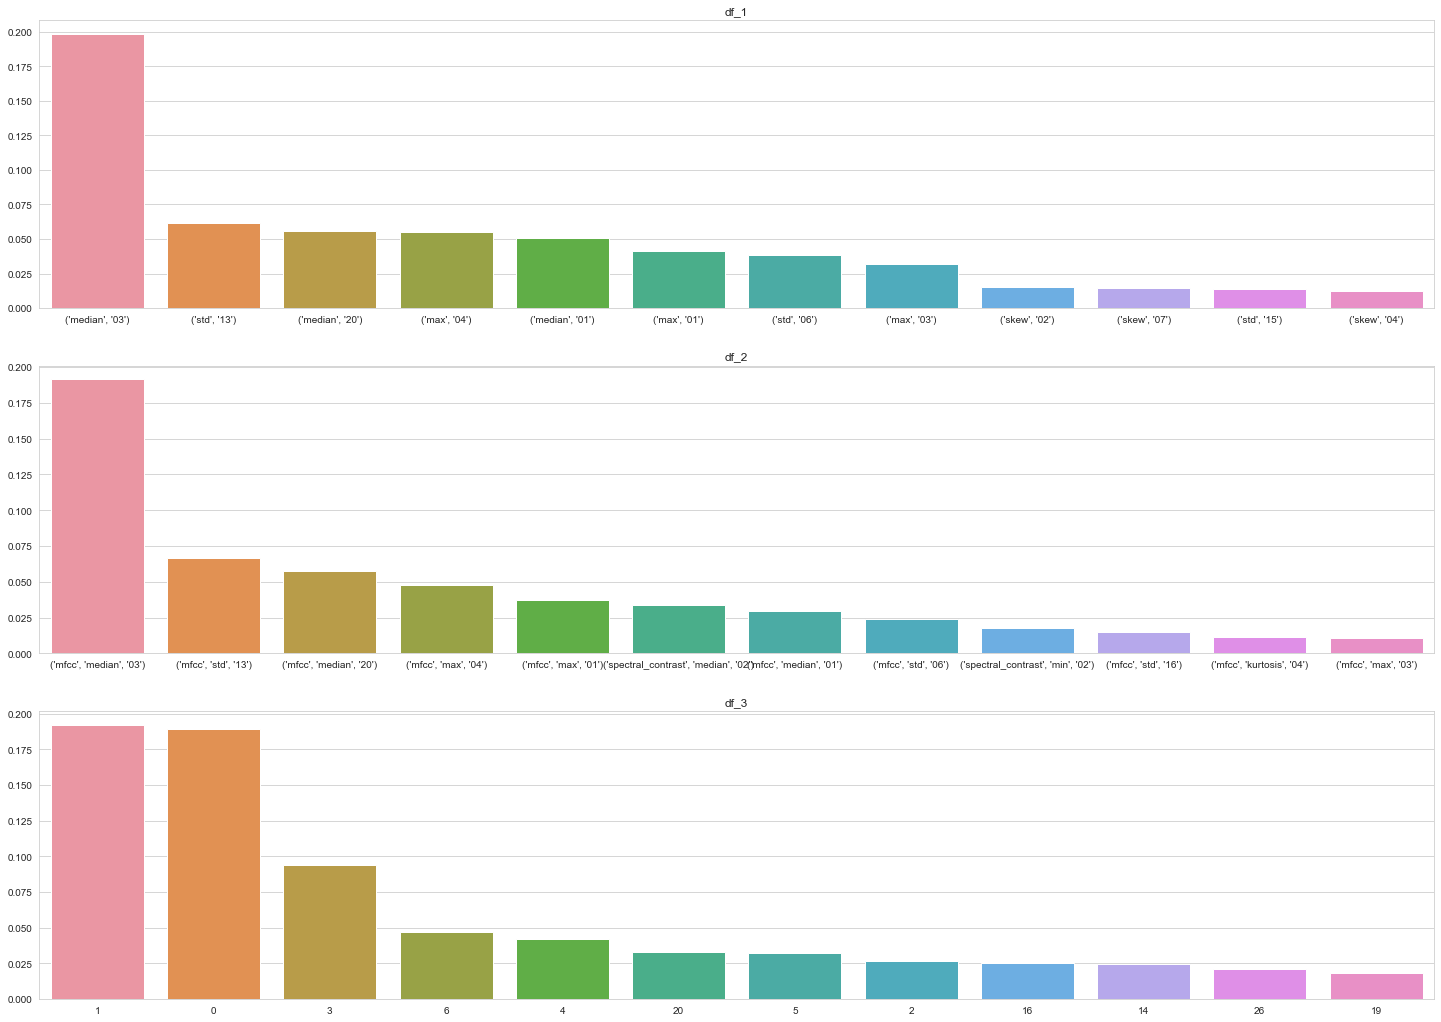

In [16]:
_, axis = plt.subplots(3, 1, figsize=(25, 18))
for i, (model_name, me) in enumerate(model_evaluations.items()):
    me.plot_feature_importances(axis[i], num_features=12, horizontal=True)
    axis[i].set_title(model_name)

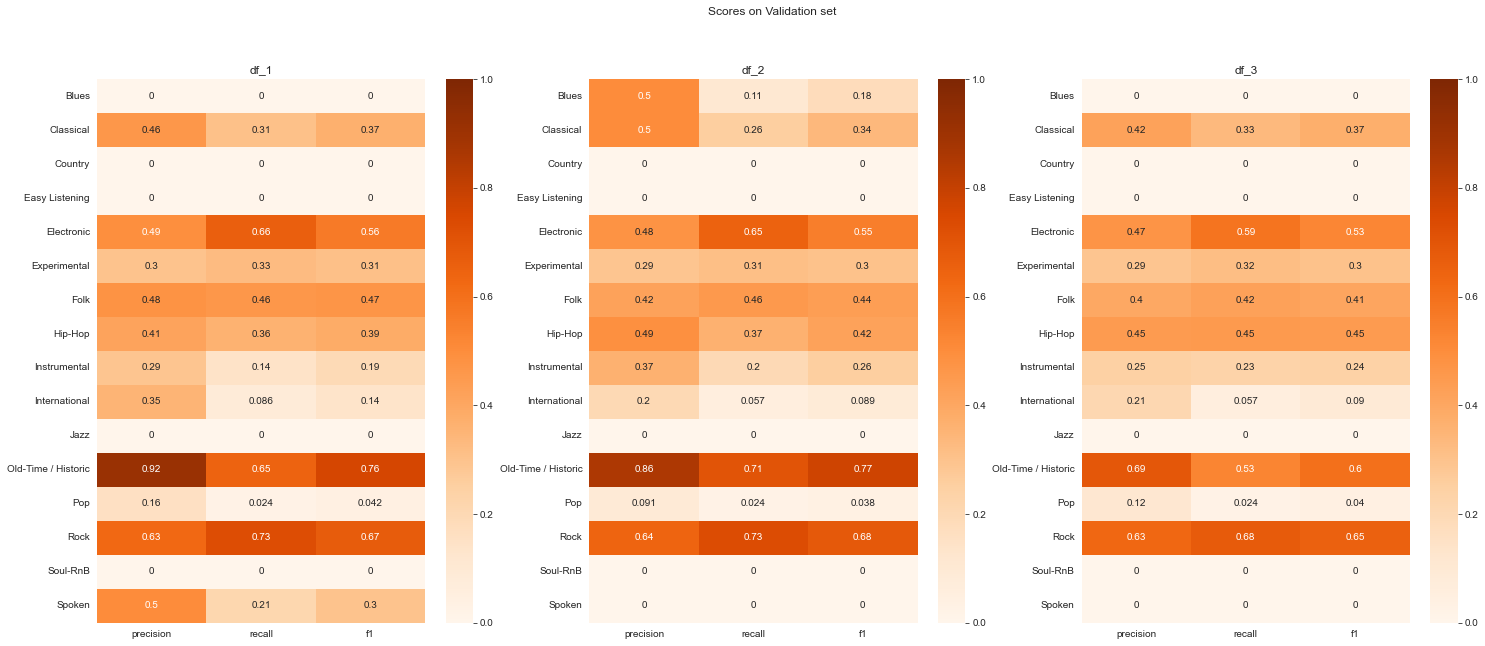

In [17]:
fig, axis = plt.subplots(1, 3, figsize=(25, 10))
fig.suptitle('Scores on Validation set')
for i, (model_name, me) in enumerate(model_evaluations.items()):
    me.plot_metrics_per_class(ax=axis[i], on_set='validation', horizontal=False)
    axis[i].set_title(model_name)

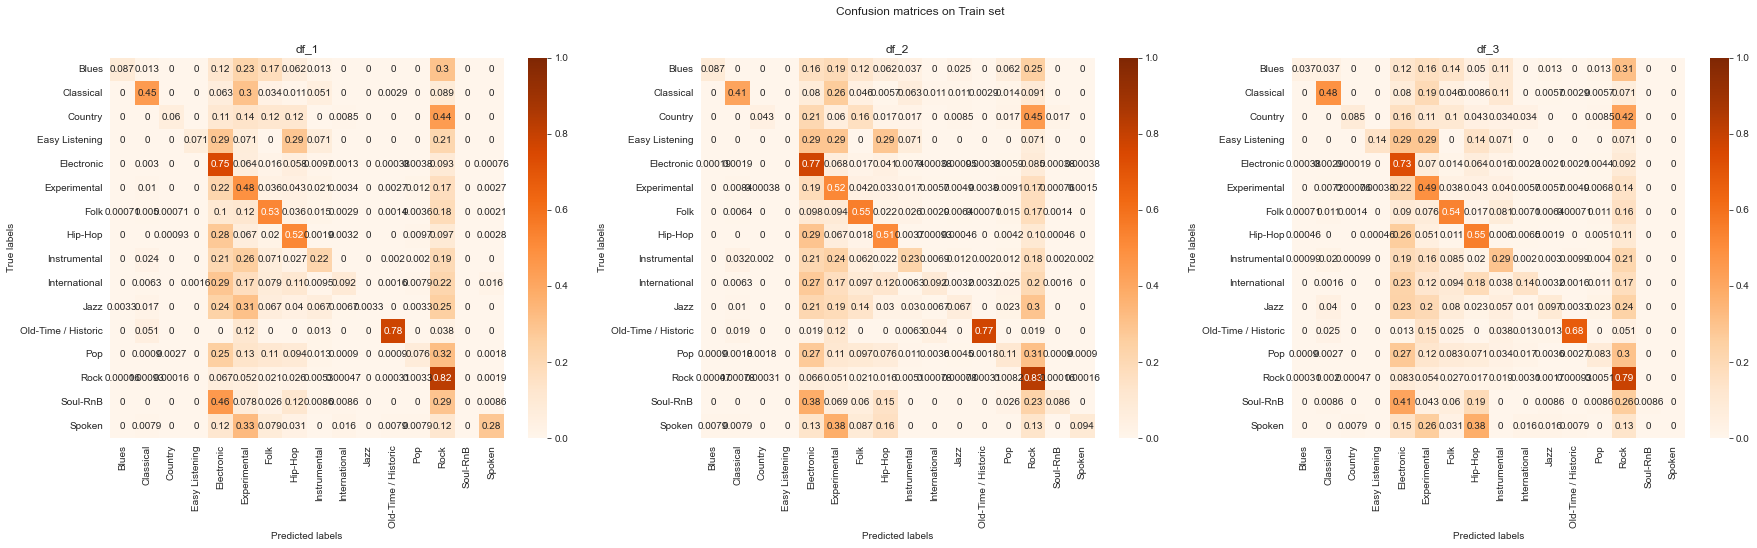

In [18]:
fig, axis = plt.subplots(1, 3, figsize=(30, 7))
fig.suptitle('Confusion matrices on Train set')
for i, (model_name, me) in enumerate(model_evaluations.items()):
    me.plot_confusion_matrix(ax=axis[i], on_set='train')
    axis[i].set_title(model_name)

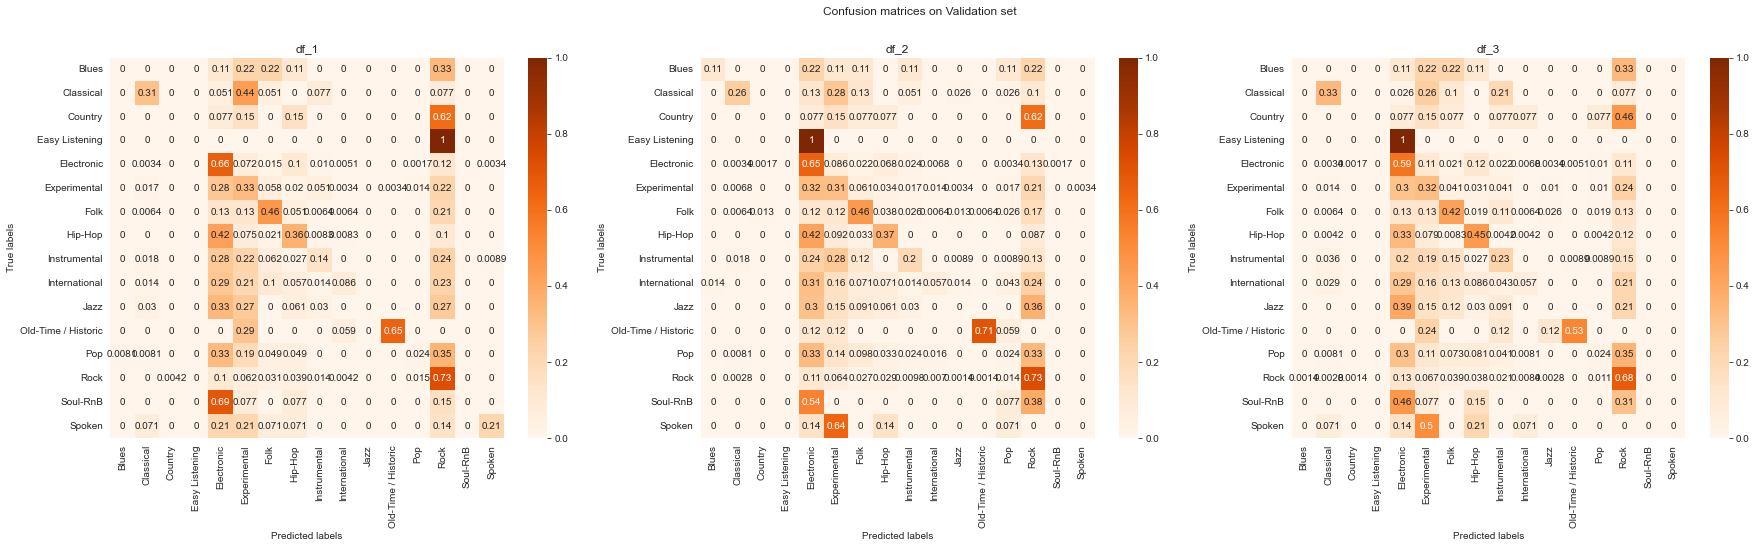

In [19]:
fig, axis = plt.subplots(1, 3, figsize=(30, 7))
fig.suptitle('Confusion matrices on Validation set')
for i, (model_name, me) in enumerate(model_evaluations.items()):
    me.plot_confusion_matrix(ax=axis[i], on_set='validation')
    axis[i].set_title(model_name)

Observations and Insights:
- The results on the validation set are very similar for all datasets.
- Based on the feature importances plot, the model predominantly uses the MFCC features. Spectral contrast seems to be the second-best predictor of genre, after MFCC.
- The first two components of the PCA are informative, while the rest are not.
- The old-time/historic genre has relatively high precision and recall on all datasets, indicating that they can differentiate it from other genres.
- MFCC features alone are not enough to differentiate Jazz, Country, Blues, Easy Listening, and Soul-RnB genres (in the context of Decision Trees).
- The Rock genre also has a relatively high recall, meaning that most of the songs that belong to this genre are recognized as such.
- The Electronic genre has a relatively high recall for all datasets.
- Most of the songs are classified as Electronic and Rock by all models. This is not surprising since most of the songs in the training set belong to these genres, resulting in a big class imbalance.
- The Soul-RnB genre is misclassified as Electronic.
- The Spoken genre is misclassified as Experimental.
- The model with MFCC features only, classifies all Easy Listening tracks as Rock, whereas the other two models classify all Easy Listening tracks as Electronic.

Based on the above observations, the main takeaway is to use a new subset of features, including MFCC Coefficients, Spectral Contrast, and ZCR, and train a model on these features.

# 3. Random Forest

In [20]:
df_4 = df[['mfcc', 'spectral_contrast', 'zcr']].copy()

In [26]:
df_4_train = df_4.loc[train_set_indexes, :].copy()
df_4_val = df_4.loc[val_set_indexes, :].copy()
df_4_test = df_4.loc[test_set_indexes, :].copy()

train_X = df_4_train
train_y = df.loc[train_set_indexes, 'genre']

val_X = df_4_val
val_y = df.loc[val_set_indexes, 'genre']

test_X = df_4_test
test_y = df.loc[test_set_indexes, 'genre']

In [22]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [57]:
params = dict(n_estimators=[50, 100, 150], max_depth=[15, 25, 30], min_samples_split=[20, 40, 60])

rf = RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1)
skf = StratifiedKFold(5, shuffle=True, random_state=23)
grid_search = GridSearchCV(rf, params, cv=3, n_jobs=-1)
grid_search.fit(pd.concat([train_X, val_X], axis=0), pd.concat([train_y, val_y], axis=0))

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [15, 25, 30],
                         'min_samples_split': [20, 40, 60],
                         'n_estimators': [50, 100, 150]})

In [58]:
grid_search.best_score_

0.597581141771144

In [68]:
grid_search.best_params_

{'max_depth': 25, 'min_samples_split': 20, 'n_estimators': 100}

In [69]:
rf_evaluation = DTClassificationEvaluation(
    model_name='df_4',
    model=grid_search.best_estimator_,
    train_X=pd.concat([train_X, val_X], axis=0),
    train_y=pd.concat([train_y, val_y], axis=0),
    # We are using the test set for evaluating the model
    val_X=test_X,
    val_y=test_y
)

Note that "validation" in this case refers to the TEST set.

In [70]:
rf_evaluation.get_scores(on_sets=['train', 'validation'], average_type='weighted')

,train,validation
accuracy,0.875638,0.604221
precision (weighted),0.887873,0.579212
recall (weighted),0.875638,0.604221
f1 (weighted),0.861457,0.559120


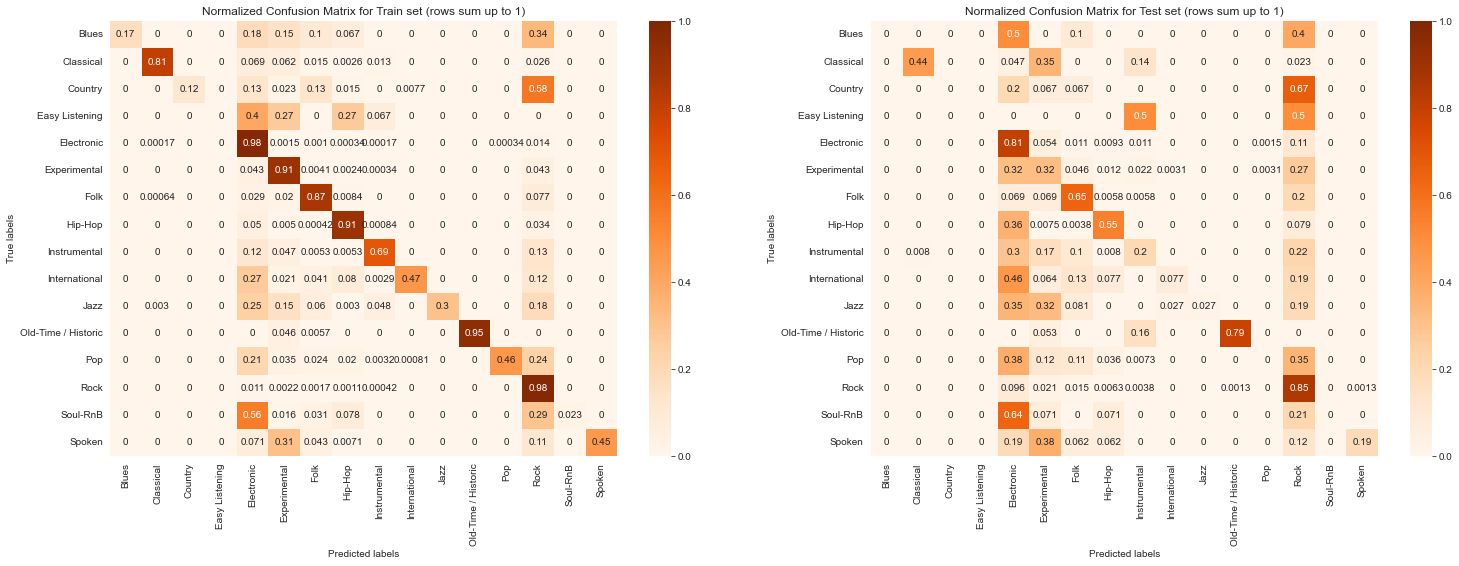

In [71]:
_, ax = plt.subplots(1, 2, figsize=(25, 8))
rf_evaluation.plot_confusion_matrix(ax=ax[0], on_set='train')
ax[0].set_title('Normalized Confusion Matrix for Train set (rows sum up to 1)')
rf_evaluation.plot_confusion_matrix(ax=ax[1], on_set='validation')
ax[1].set_title('Normalized Confusion Matrix for Test set (rows sum up to 1)')
plt.show()

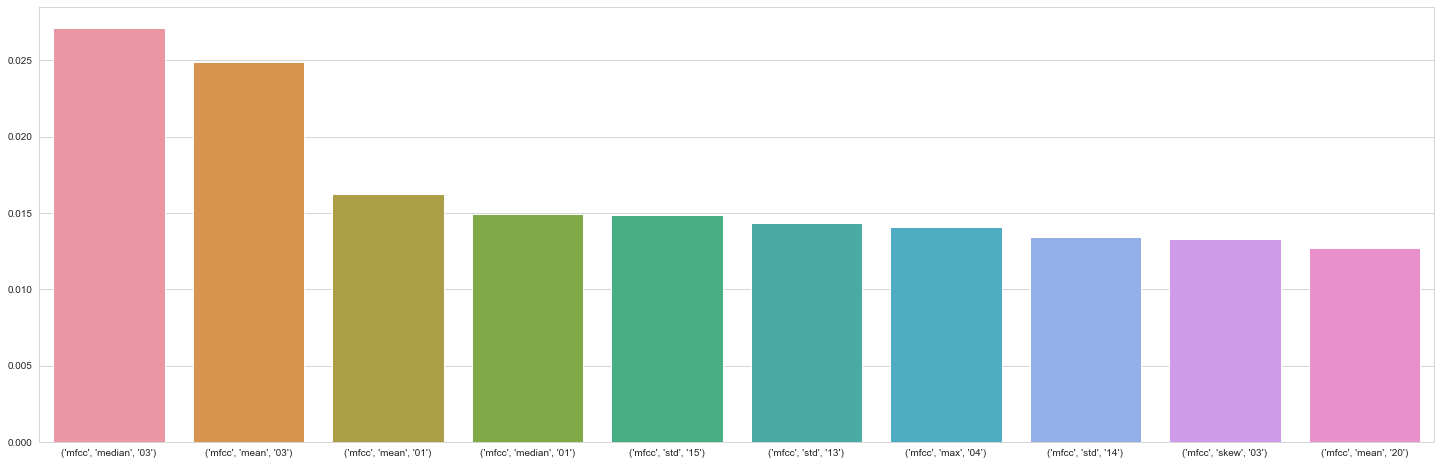

In [72]:
_, axis = plt.subplots(1, 1, figsize=(25, 8))
rf_evaluation.plot_feature_importances(ax=axis, horizontal=True)

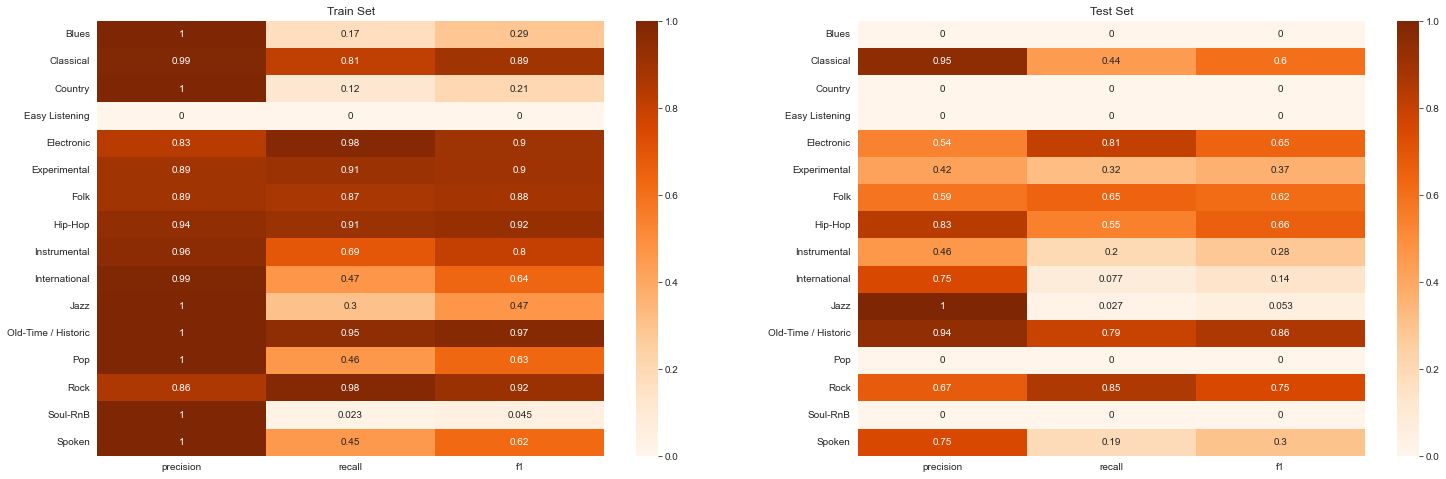

In [77]:
_, ax = plt.subplots(1, 2, figsize=(25, 8))
rf_evaluation.plot_metrics_per_class(ax=ax[0], on_set='train', horizontal=False)
ax[0].set_title('Train Set')
rf_evaluation.plot_metrics_per_class(ax=ax[1], on_set='validation', horizontal=False)
ax[1].set_title('Test Set')
plt.show()

The Random Forest model was ultimately trained using only MFCC features. Compared to Decision Tree models, the Random Forest is less prone to overfitting and yields better results.
However, Decision trees and random forests are not ideal for the task at hand since they only consider one feature at a time when making axis-aligned splits. This approach is unsuitable since the features being analyzed are highly interconnected. Namely, The MFCC features (and others) are interacting features that can distinguish between classes together, but not necessarily in isolation.
In order to overcome this limitation, a more appropriate model would need to be able to examine multiple features simultaneously (such as mean, median, standard deviation of the MFCCs).
Despite using the Random Forest model, a significant number of tracks are still classified as Electronic, indicating that the problem of class imbalance remains a significant challenge.

TODO:
- use metadata information for a better train, validation, test split